# Text classification with an RNN

## Setup

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteF1HEIX/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteF1HEIX/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteF1HEIX/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'The United States was still fighting World War II (the movie was released in between VE day and VJ day). Any studio worth its salt was either making fighting movies where fearless American soldiers beat the enemy, or Americans in general were singing and dancing. Technicolor Musicals were what America thrived on in the depressing days when everything was rationed. Most musicals of the day were simply a bunch of musical numbers strung together with the best available plot slipped in to fill time til the next musical number! I get the feeling now that the people reviewing this movie were all born after 1970. Depressing how quickly we forget.<br /><br />This film could\'ve been called "The Search for Jose Iturbi" but now everyone wonders why. Allow me to explain. From 1929--his arrival in America--until his death in 1980, Iturbi was one of the finest pianists to grace a concert stage. He agreed to do a few movies in 1942, but Hollywood had been after him for nearly a decade at 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   1,   1, ...,   0,   0,   0],
       [ 80,   5,  32, ...,   0,   0,   0],
       [565,   1,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The United States was still fighting World War II (the movie was released in between VE day and VJ day). Any studio worth its salt was either making fighting movies where fearless American soldiers beat the enemy, or Americans in general were singing and dancing. Technicolor Musicals were what America thrived on in the depressing days when everything was rationed. Most musicals of the day were simply a bunch of musical numbers strung together with the best available plot slipped in to fill time til the next musical number! I get the feeling now that the people reviewing this movie were all born after 1970. Depressing how quickly we forget.<br /><br />This film could\'ve been called "The Search for Jose Iturbi" but now everyone wonders why. Allow me to explain. From 1929--his arrival in America--until his death in 1980, Iturbi was one of the finest pianists to grace a concert stage. He agreed to do a few movies in 1942, but Hollywood had been after him for nearly a decade a

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

**Masking** is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.

Now that all samples have a uniform length, the model must be informed that some part of the data is actually padding and should be ignored. That mechanism is masking.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. **All the layers after the `Embedding` support masking:**

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. 

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 40s 86ms/step - loss: 0.6411 - accuracy: 0.5737 - val_loss: 0.4934 - val_accuracy: 0.7766
Epoch 2/10
391/391 [==============================] - 32s 82ms/step - loss: 0.4273 - accuracy: 0.8106 - val_loss: 0.3861 - val_accuracy: 0.8161
Epoch 3/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3550 - accuracy: 0.8443 - val_loss: 0.3694 - val_accuracy: 0.8536
Epoch 4/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3328 - accuracy: 0.8578 - val_loss: 0.3312 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3207 - accuracy: 0.8628 - val_loss: 0.3299 - val_accuracy: 0.8526
Epoch 6/10
391/391 [==============================] - 32s 80ms/step - loss: 0.3159 - accuracy: 0.8687 - val_loss: 0.3377 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3109 - accuracy: 0.8684 - val_loss: 0.3373 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 16s 40ms/step - loss: 0.3207 - accuracy: 0.8583
Test Loss: 0.32067257165908813
Test Accuracy: 0.8583199977874756


(0.0, 0.6580014318227768)

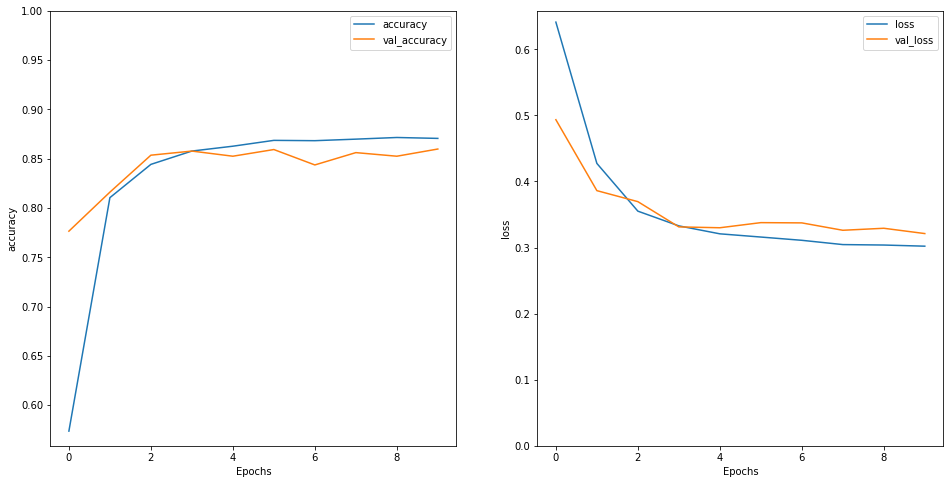

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [ ]:
predictions

array([[0.38639325]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 71s 143ms/step - loss: 0.6196 - accuracy: 0.5985 - val_loss: 0.4283 - val_accuracy: 0.8219
Epoch 2/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3761 - accuracy: 0.8379 - val_loss: 0.3730 - val_accuracy: 0.8115
Epoch 3/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3326 - accuracy: 0.8586 - val_loss: 0.3300 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3206 - accuracy: 0.8628 - val_loss: 0.3319 - val_accuracy: 0.8411
Epoch 5/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3123 - accuracy: 0.8676 - val_loss: 0.3185 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3082 - accuracy: 0.8709 - val_loss: 0.3224 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3040 - accuracy: 0.8717 - val_loss: 0.3310 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 25s 65ms/step - loss: 0.3221 - accuracy: 0.8552
Test Loss: 0.3221374750137329
Test Accuracy: 0.855239987373352


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-2.3033905]]


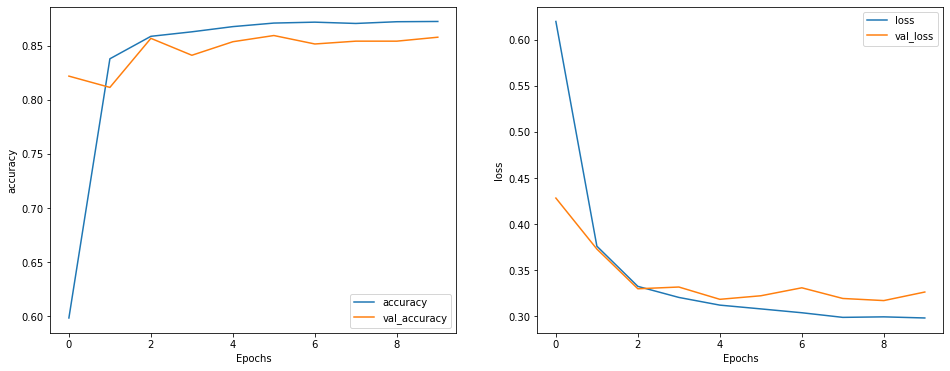

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')